In [2]:
import numpy as np
import pandas as pd
import patsy

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


In [3]:
#Import CSV 
train_data = pd.read_csv("./datasets/train.csv")
test_data = pd.read_csv("./datasets/test.csv")

# 2.4 Identifying Numerical features

After looking at the EDA within categorical features, we will now looking at the numerical features. 

In [4]:
#identify categorical columns
#Filtering out features with dtypes that are NOT 'object'

numerical_cols = train_data.loc[:, train_data.dtypes != 'O']
numerical_cols

Id        PID  MS SubClass  Lot Frontage  Lot Area  Overall Qual  \
0      109  533352170           60           NaN     13517             6   
1      544  531379050           60          43.0     11492             7   
2      153  535304180           20          68.0      7922             5   
3      318  916386060           60          73.0      9802             5   
4      255  906425045           50          82.0     14235             6   
...    ...        ...          ...           ...       ...           ...   
2046  1587  921126030           20          79.0     11449             8   
2047   785  905377130           30           NaN     12342             4   
2048   916  909253010           50          57.0      7558             6   
2049   639  535179160           20          80.0     10400             4   
2050    10  527162130           60          60.0      7500             7   

      Overall Cond  Year Built  Year Remod/Add  Mas Vnr Area  ...  \
0                8        1976            2005         289.0  ...   
1                5        1996            1997         132.0  ...   
2                7        1953            2007           0.0  ...   
3                5        2006            2007           0.0  ...   
4                8        1900            1993           0.0  ...   
...            ...         ...             ...           ...  ...   
2046             5        2007            2007           0.0  ...   
2047             5        1940            1950           0.0  ...   
2048             6        1928            1950           0.0  ...   
2049             5        1956            1956           0.0  ...   
2050             5        1999            1999           0.0  ...   

      Wood Deck SF  Open Porch SF  Enclosed Porch  3Ssn Porch  Screen Porch  \
0                0             44               0           0             0   
1                0             74               0           0             0   
2                0             52               0           0             0   
3              100              0               0           0             0   
4                0             59               0           0             0   
...            ...            ...             ...         ...           ...   
2046             0            276               0           0             0   
2047           158              0               0           0             0   
2048             0              0               0           0             0   
2049             0            189             140           0             0   
2050           140             60               0           0             0   

      Pool Area  Misc Val  Mo Sold  Yr Sold  SalePrice  
0             0         0        3     2010     130500  
1             0         0        4     2009     220000  
2             0         0        1     2010     109000  
3             0         0        4     2010     174000  
4             0         0        3     2010     138500  
...         ...       ...      ...      ...        ...  
2046          0         0        1     2008     298751  
2047          0         0        3     2009      82500  
2048          0         0        3     2009     177000  
2049          0         0       11     2009     144000  
2050          0         0        6     2010     189000  

[2051 rows x 39 columns]

In [5]:
#columns headers for the numerical features 
numerical_cols.columns

Index(['Id', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces',
       'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
       'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'SalePrice'],
      dtype='object')

# 2.5 Numerical columns which are not features of a house will be dropped. 


In [6]:
#yr sold will be retained to calculate the age of the house when it was sold
non_features = ['Id', 'PID', 'Mo Sold']

In [7]:
[numerical_cols.drop(col, axis = 1, inplace = True) for col in non_features]

C:\Users\wongs\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


[None, None, None]

In [8]:
#checking whether the numerical columns that are not considered as features of a house has been dropped and 
#a new additional column - House Age
numerical_cols.columns

Index(['MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces',
       'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
       'Pool Area', 'Misc Val', 'Yr Sold', 'SalePrice'],
      dtype='object')

In [9]:
numerical_cols.describe().T

count           mean           std      min       25%  \
MS SubClass      2051.0      57.008776     42.824223     20.0      20.0   
Lot Frontage     1721.0      69.055200     23.260653     21.0      58.0   
Lot Area         2051.0   10065.208191   6742.488909   1300.0    7500.0   
Overall Qual     2051.0       6.112140      1.426271      1.0       5.0   
Overall Cond     2051.0       5.562165      1.104497      1.0       5.0   
Year Built       2051.0    1971.708922     30.177889   1872.0    1953.5   
Year Remod/Add   2051.0    1984.190151     21.036250   1950.0    1964.5   
Mas Vnr Area     2029.0      99.695909    174.963129      0.0       0.0   
BsmtFin SF 1     2050.0     442.300488    461.204124      0.0       0.0   
BsmtFin SF 2     2050.0      47.959024    165.000901      0.0       0.0   
Bsmt Unf SF      2050.0     567.728293    444.954786      0.0     220.0   
Total Bsmt SF    2050.0    1057.987805    449.410704      0.0     793.0   
1st Flr SF       2051.0    1164.488055    396.446923    334.0     879.5   
2nd Flr SF       2051.0     329.329108    425.671046      0.0       0.0   
Low Qual Fin SF  2051.0       5.512921     51.068870      0.0       0.0   
Gr Liv Area      2051.0    1499.330083    500.447829    334.0    1129.0   
Bsmt Full Bath   2049.0       0.427526      0.522673      0.0       0.0   
Bsmt Half Bath   2049.0       0.063446      0.251705      0.0       0.0   
Full Bath        2051.0       1.577279      0.549279      0.0       1.0   
Half Bath        2051.0       0.371039      0.501043      0.0       0.0   
Bedroom AbvGr    2051.0       2.843491      0.826618      0.0       2.0   
Kitchen AbvGr    2051.0       1.042906      0.209790      0.0       1.0   
TotRms AbvGrd    2051.0       6.435885      1.560225      2.0       5.0   
Fireplaces       2051.0       0.590931      0.638516      0.0       0.0   
Garage Yr Blt    1937.0    1978.707796     25.441094   1895.0    1961.0   
Garage Cars      2050.0       1.776585      0.764537      0.0       1.0   
Garage Area      2050.0     473.671707    215.934561      0.0     319.0   
Wood Deck SF     2051.0      93.833740    128.549416      0.0       0.0   
Open Porch SF    2051.0      47.556802     66.747241      0.0       0.0   
Enclosed Porch   2051.0      22.571916     59.845110      0.0       0.0   
3Ssn Porch       2051.0       2.591419     25.229615      0.0       0.0   
Screen Porch     2051.0      16.511458     57.374204      0.0       0.0   
Pool Area        2051.0       2.397855     37.782570      0.0       0.0   
Misc Val         2051.0      51.574354    573.393985      0.0       0.0   
Yr Sold          2051.0    2007.775719      1.312014   2006.0    2007.0   
SalePrice        2051.0  181469.701609  79258.659352  12789.0  129825.0   

                      50%        75%       max  
MS SubClass          50.0      70.00     190.0  
Lot Frontage         68.0      80.00     313.0  
Lot Area           9430.0   11513.50  159000.0  
Overall Qual          6.0       7.00      10.0  
Overall Cond          5.0       6.00       9.0  
Year Built         1974.0    2001.00    2010.0  
Year Remod/Add     1993.0    2004.00    2010.0  
Mas Vnr Area          0.0     161.00    1600.0  
BsmtFin SF 1        368.0     733.75    5644.0  
BsmtFin SF 2          0.0       0.00    1474.0  
Bsmt Unf SF         474.5     811.00    2336.0  
Total Bsmt SF       994.5    1318.75    6110.0  
1st Flr SF         1093.0    1405.00    5095.0  
2nd Flr SF            0.0     692.50    1862.0  
Low Qual Fin SF       0.0       0.00    1064.0  
Gr Liv Area        1444.0    1728.50    5642.0  
Bsmt Full Bath        0.0       1.00       3.0  
Bsmt Half Bath        0.0       0.00       2.0  
Full Bath             2.0       2.00       4.0  
Half Bath             0.0       1.00       2.0  
Bedroom AbvGr         3.0       3.00       8.0  
Kitchen AbvGr         1.0       1.00       3.0  
TotRms AbvGrd         6.0       7.00      15.0  
Fireplaces            1.0       1.00       4.0  
Garage Yr Blt    

Here are some preliminary observations from the numerical columns

1) The Min Sale Price of a house is `$12,789`,  Max Sale Price is `$611,657` with a mean average Sale Price of `$181,484`.

2) The Min age of a house sold is `-1`, Max age is `136` and the average age is `36`. Since the min age is -1 we can assume that the house was sold before it was fully built. 

3) The Min Total Bsmt SF is `0.0` a nd the Max is `6110` square feet. The min is at 0.0 as some houses do not come with basements                                                        

# 2.6 Plotting preliminary visualisations for numerical columns 
### Heatmap visualisations

#### The top numerical features with strong correlation with prices are Overall Qual, Gr Living Area, Garage Area, Garage Cars, Total Bsmt SF and 1st Flr SF.

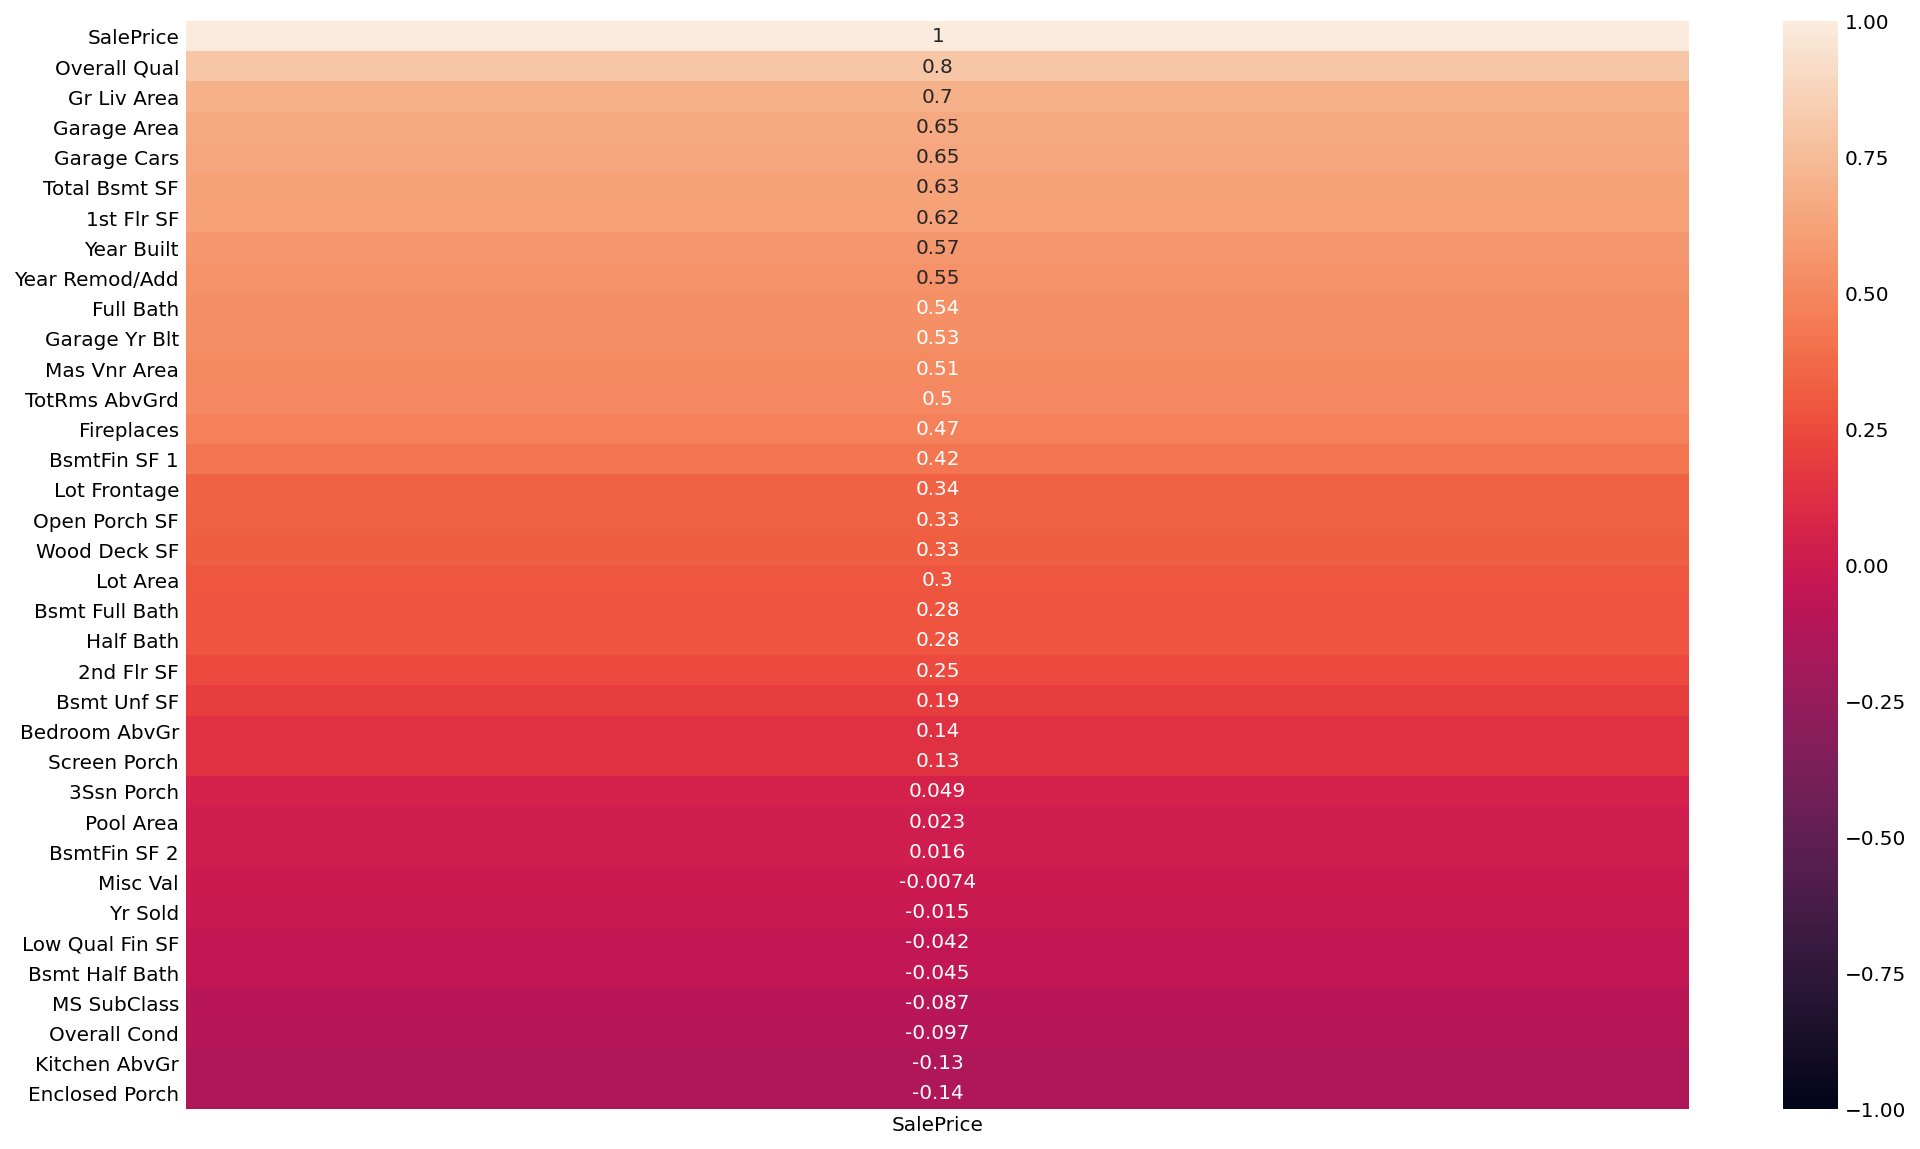

In [10]:
#Plot the correlation of the numerical features in relation to the sale price, sorted in descending order.
plt.figure(figsize=(15, 10))

sns.heatmap(numerical_cols.corr()[['SalePrice']].sort_values('SalePrice', ascending=False), annot=True,vmin=-1, vmax=1 );

<ipython-input-11-e76cd9ba907b>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(numerical_cols[corr_cols].corr(), dtype=np.bool)


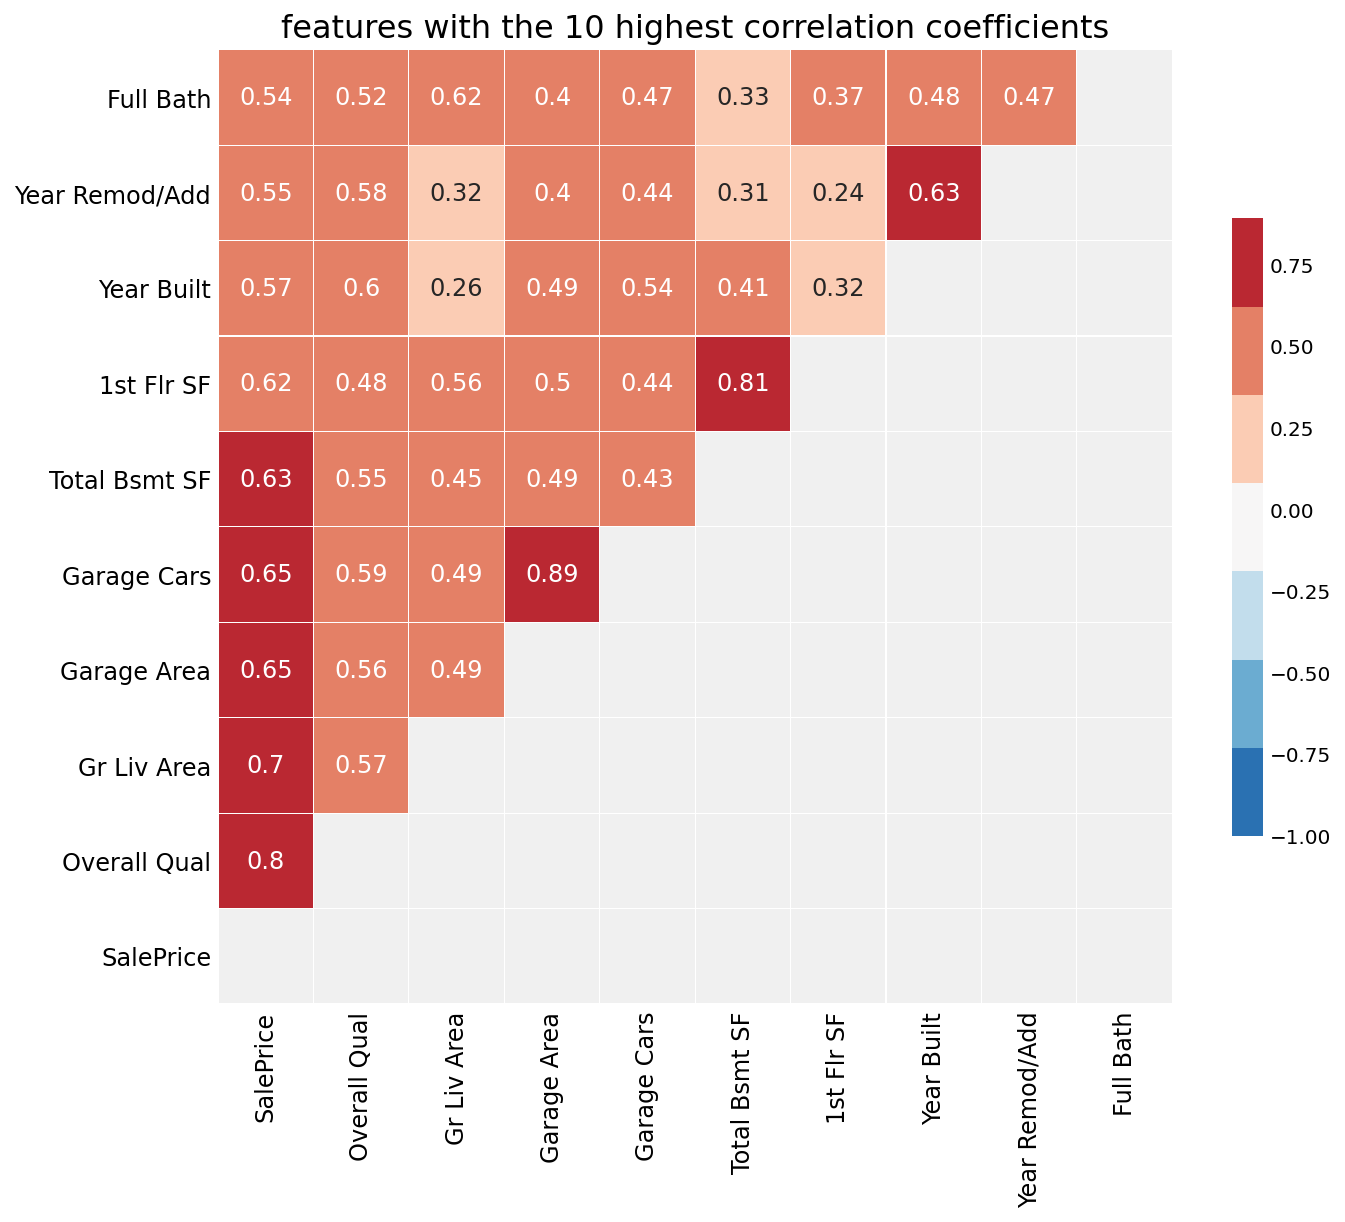

In [11]:
#create a heatmap of the top 10 features with highest correlation
corr_cols = numerical_cols.corr().nlargest(10, 'SalePrice').index

# create heatmap
mask = np.zeros_like(numerical_cols[corr_cols].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(numerical_cols[corr_cols].corr(), 
            annot=True, 
            square= True, 
            mask = mask,
            cmap=sns.color_palette("RdBu_r", 7),
            annot_kws={'size': 12},
            cbar_kws={"shrink": 0.5},
            linewidth = 0.1,
            yticklabels=corr_cols.values, 
            xticklabels=corr_cols.values,
            vmin = -1)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.tick_params(labelsize=12)
plt.title('features with the 10 highest correlation coefficients', fontsize=16)
plt.tight_layout()

Multicollinearity was observed for these variables.

1) Garage Cars and Garage Area

2) 1st Flr SF and Total Bsmt SF

3) Year Remod/Add anf Year Built

Future decisions will be made during the feature engineering.

### Scatterplot Visualisations


From the scatterplots below, one can see a strong positive linear relationship between SalePrice and several of the features, for e.g., Overall Qual, Year Built, Total Bsmt SF, 1st Flr SF, GR Liv Area, totrmsabvgrd, Garage Area.

Outliers were also observed in a few features:

1) Lot Frontage

2) Lot Area

3) BsmtFin SF 2

4) Total Bsmt SF

5) BsmtFin SF 1

6) Mas Vnr Area

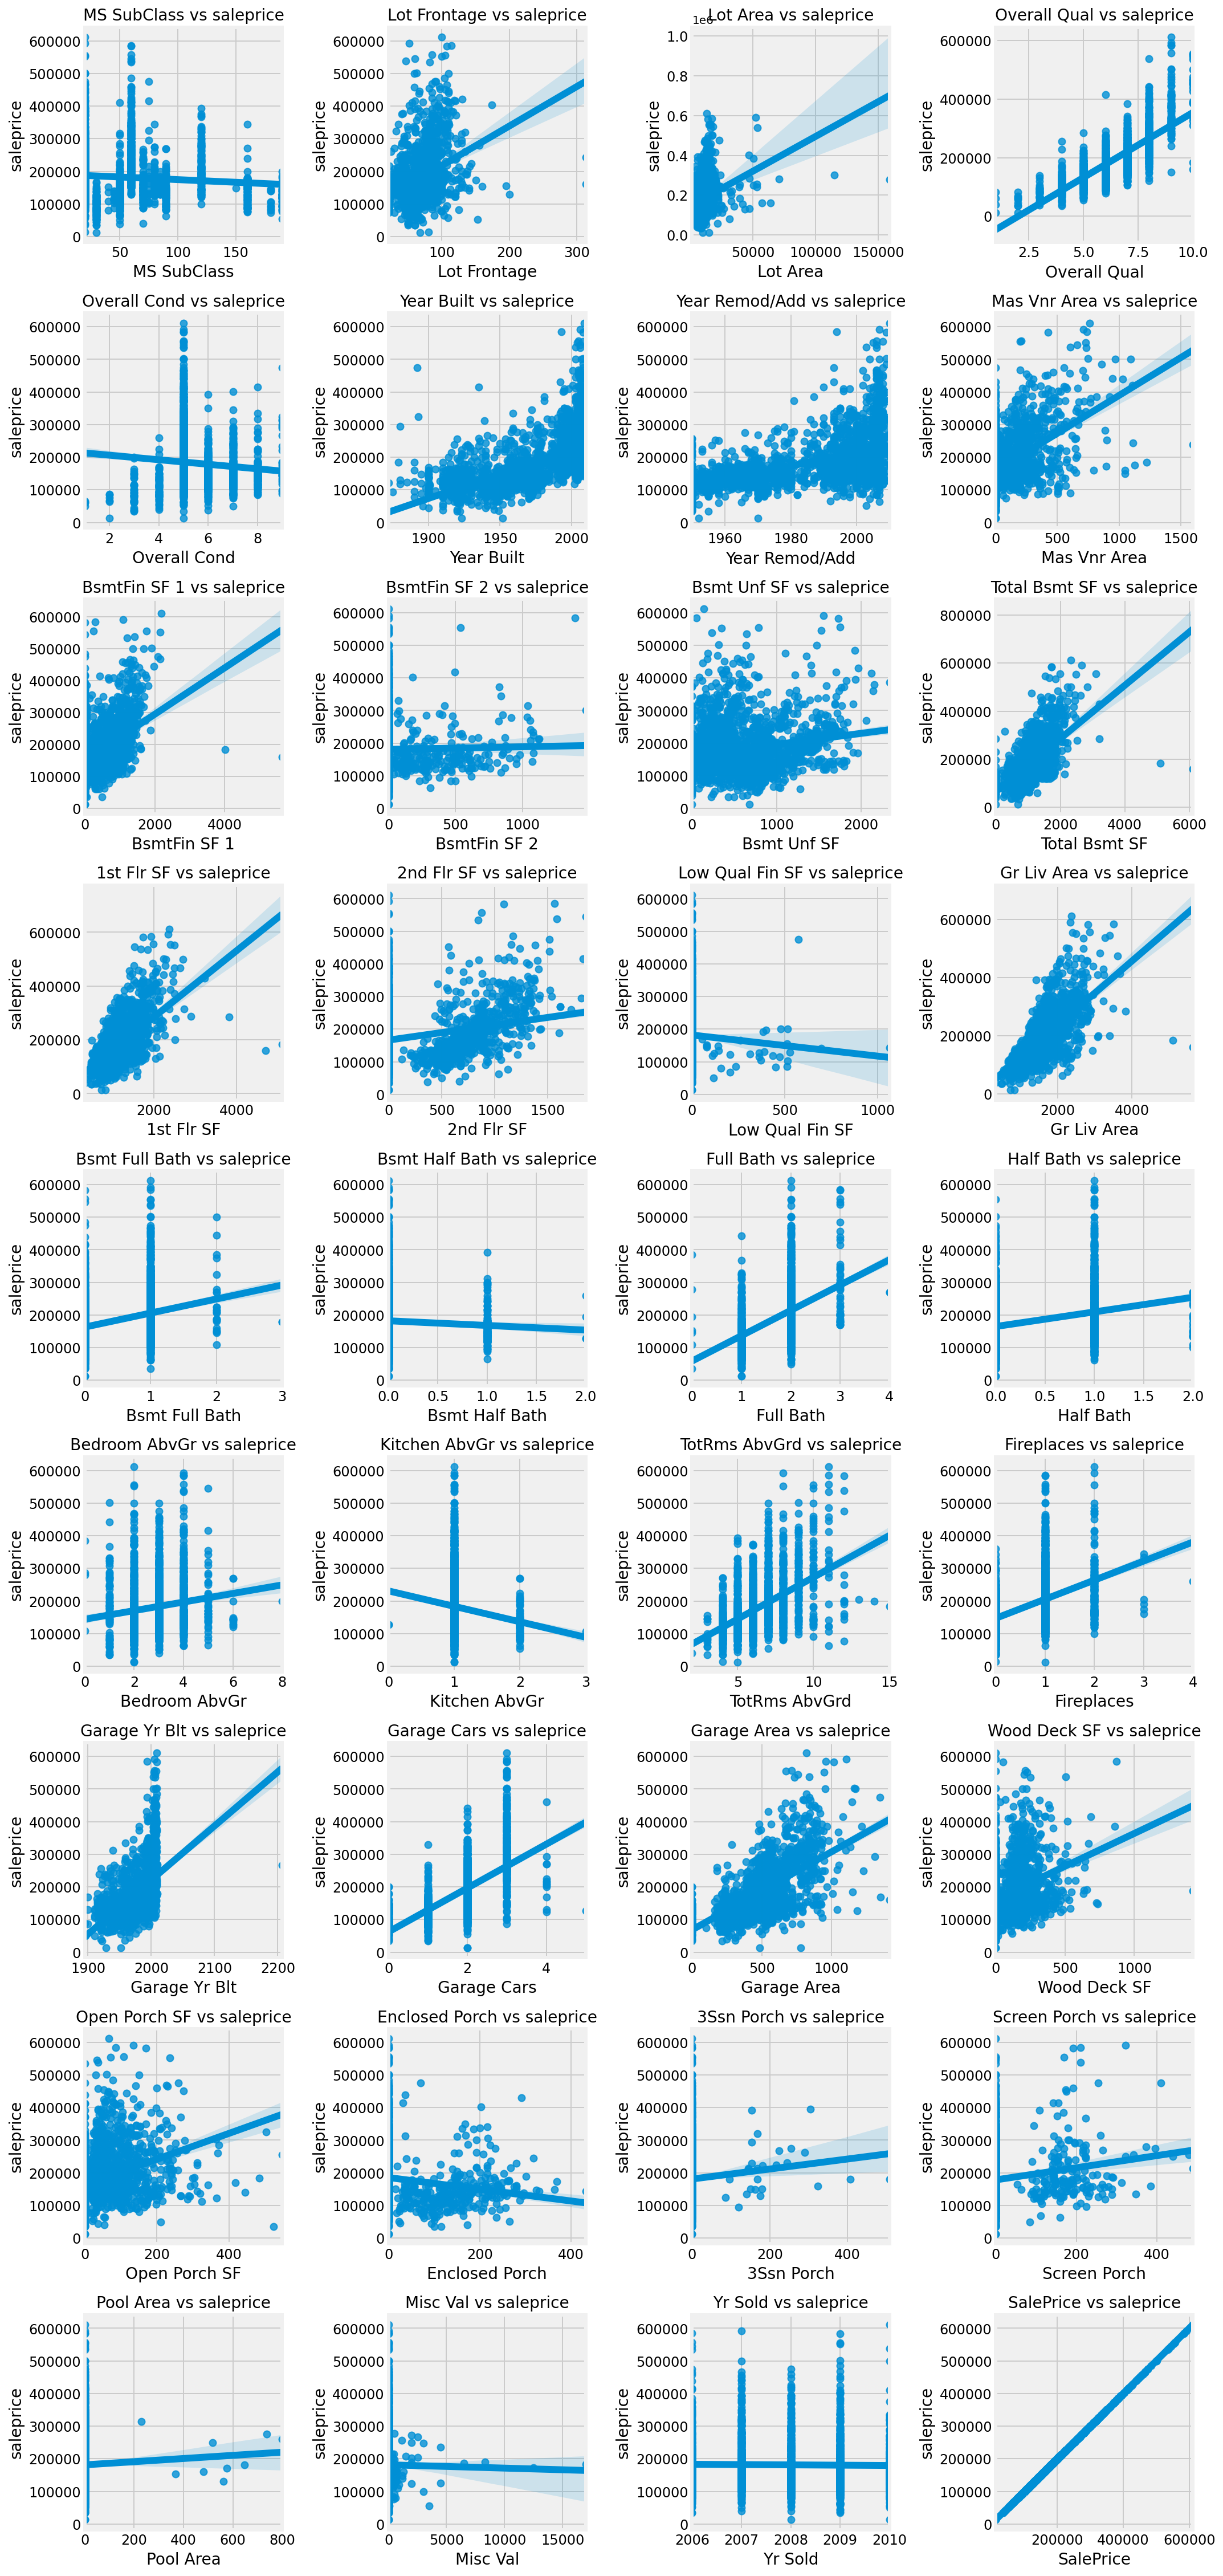

In [12]:
#create subplots of scatter plots to observe relationships of the numerical features with sale price 
nrows = int(np.ceil(len(numerical_cols.columns)/4)) 
fig, ax = plt.subplots(nrows=nrows, ncols=4,figsize=(15, nrows*3.5)) 
ax = ax.ravel() 
for i, column in enumerate(numerical_cols.columns): 
    sns.regplot(y=train_data.SalePrice, x=train_data[column],ax=ax[i])
    ax[i].set_title(f'{column} vs saleprice',fontsize=14)  
    ax[i].tick_params(labelsize=12)
    ax[i].set_xlabel(column, fontsize=14)
    ax[i].set_ylabel('saleprice', fontsize=14)
plt.tight_layout()

# 3.  Feature Engineering & Additional changes 

Now that we filled in the missing data, clean the data and did a preliminary visualization, we can create some new variables from the existing ones.

1) Looking at the correlations of the categorical features, it was observed that Total Bsmt SF, 1st flr sf have very high positive correlation. I decided to create a new column named `Total SF` to include `Total Bsmt SF`, `1st Flr SF`and `2nd Flr SF`.

2) Create a new column called `House Age` to determine when the houses were sold after being built.

3) Create a new column called `Age Remod` to determine when the houses were sold after remod.

4) `Garage Area` and `Garage Cars` have the same correlation(0.65). Assuming that the the number of cars in a garage is very much dependent on the garage area, I have decided to remove `Garage Cars` and retain `Garage Area` as a feature. 

# 3.1  Creating a additional column - House Age, Total SF

In [13]:
#Add new columns 
train_data["House Age"] = train_data["Yr Sold"] - train_data["Year Built"]
train_data["Total SF"] = (train_data["Total Bsmt SF"] + train_data["1st Flr SF"] + train_data["2nd Flr SF"]) 
train_data["Age Remod"] = train_data["Yr Sold"] - train_data ["Year Remod/Add"]

In [14]:
train_data.isnull().sum()

Id                0
PID               0
MS SubClass       0
MS Zoning         0
Lot Frontage    330
               ... 
Sale Type         0
SalePrice         0
House Age         0
Total SF          1
Age Remod         0
Length: 84, dtype: int64

In [15]:
#Drop column 
train_data.drop("Garage Cars", axis = 1, inplace = True)

In [16]:
#Checking for new columns and dropped columns 
numerical_cols = train_data.loc[:, train_data.dtypes != 'O']
[numerical_cols.drop(col, axis = 1, inplace = True) for col in non_features]
numerical_cols.head()


C:\Users\wongs\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


MS SubClass  Lot Frontage  Lot Area  Overall Qual  Overall Cond  \
0           60           NaN     13517             6             8   
1           60          43.0     11492             7             5   
2           20          68.0      7922             5             7   
3           60          73.0      9802             5             5   
4           50          82.0     14235             6             8   

   Year Built  Year Remod/Add  Mas Vnr Area  BsmtFin SF 1  BsmtFin SF 2  ...  \
0        1976            2005         289.0         533.0           0.0  ...   
1        1996            1997         132.0         637.0           0.0  ...   
2        1953            2007           0.0         731.0           0.0  ...   
3        2006            2007           0.0           0.0           0.0  ...   
4        1900            1993           0.0           0.0           0.0  ...   

   Enclosed Porch  3Ssn Porch  Screen Porch  Pool Area  Misc Val  Yr Sold  \
0               0           0             0          0         0     2010   
1               0           0             0          0         0     2009   
2               0           0             0          0         0     2010   
3               0           0             0          0         0     2010   
4               0           0             0          0         0     2010   

   SalePrice  House Age  Total SF  Age Remod  
0     130500         34    2204.0          5  
1     220000         13    3035.0         12  
2     109000         57    2114.0          3  
3     174000          4    1828.0          3  
4     138500        110    2121.0         17  

[5 rows x 38 columns]

# 3.2 Heatmap visualization with new numerical features

Creating a heatmap with the newly added columns to find out the top numerical variables affecting sale price, the top 5 variables are 

1) Overall Qual

2) Total SF

3) Gr Liv Area

4) Garage Area

5) Year Built 

*Please note that `Total Bsmt SF` and `1st Flr SF` was not included as we have `Total SF` as one of the top variables. 

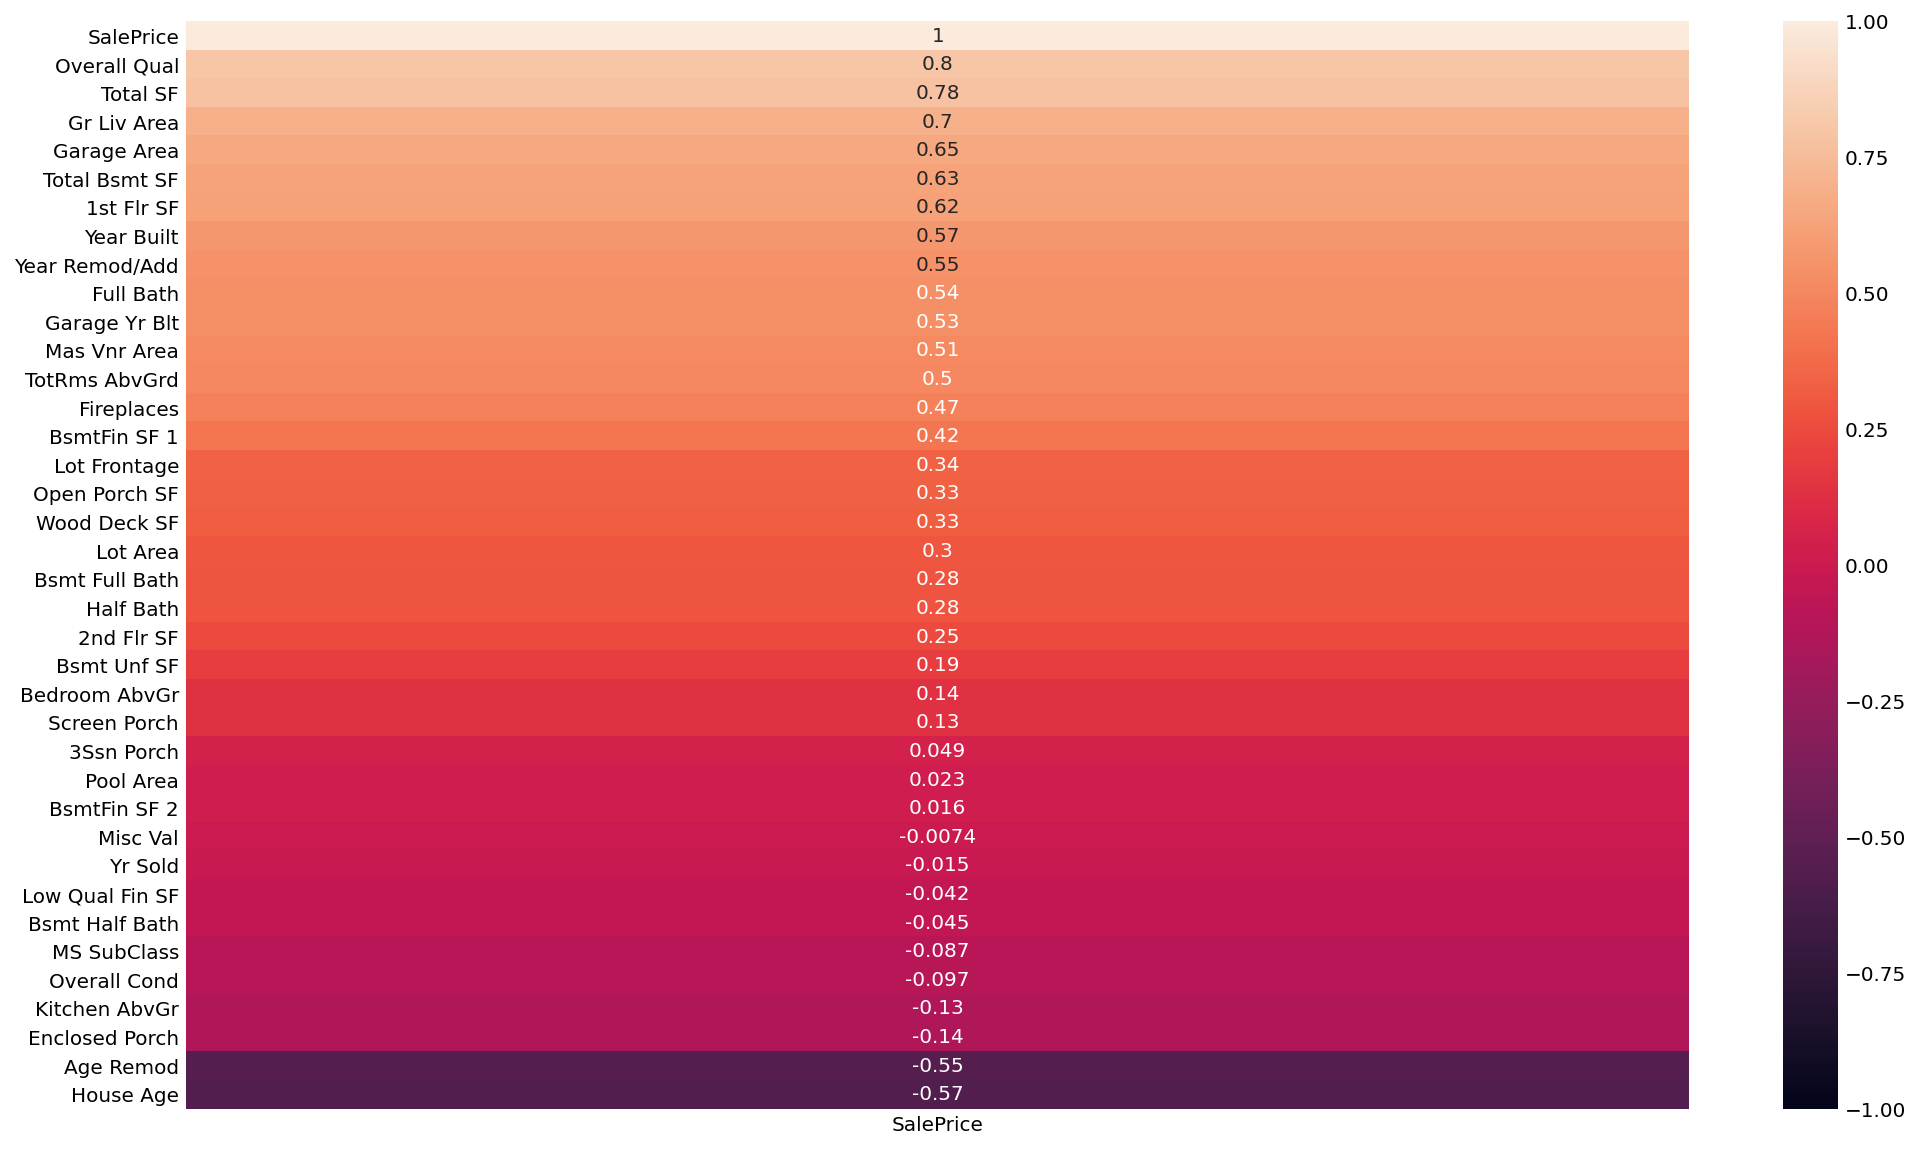

In [17]:
#Plot the correlation of the numerical features in relation to the sale price, sorted in descending order.
plt.figure(figsize=(15, 10))

sns.heatmap(numerical_cols.corr()[['SalePrice']].sort_values('SalePrice', ascending=False), annot=True,vmin=-1, vmax=1 );

# 3.3 Scatterplot with top variables 

In [18]:
#Create a subset of the top variables with the highest correlation to plot a scatter plot
top_df = train_data[['Overall Qual', 'Total SF', 'Gr Liv Area', 'Garage Area', 'Year Built']]
top_df.head()

Overall Qual  Total SF  Gr Liv Area  Garage Area  Year Built
0             6    2204.0         1479        475.0        1976
1             7    3035.0         2122        559.0        1996
2             5    2114.0         1057        246.0        1953
3             5    1828.0         1444        400.0        2006
4             6    2121.0         1445        484.0        1900

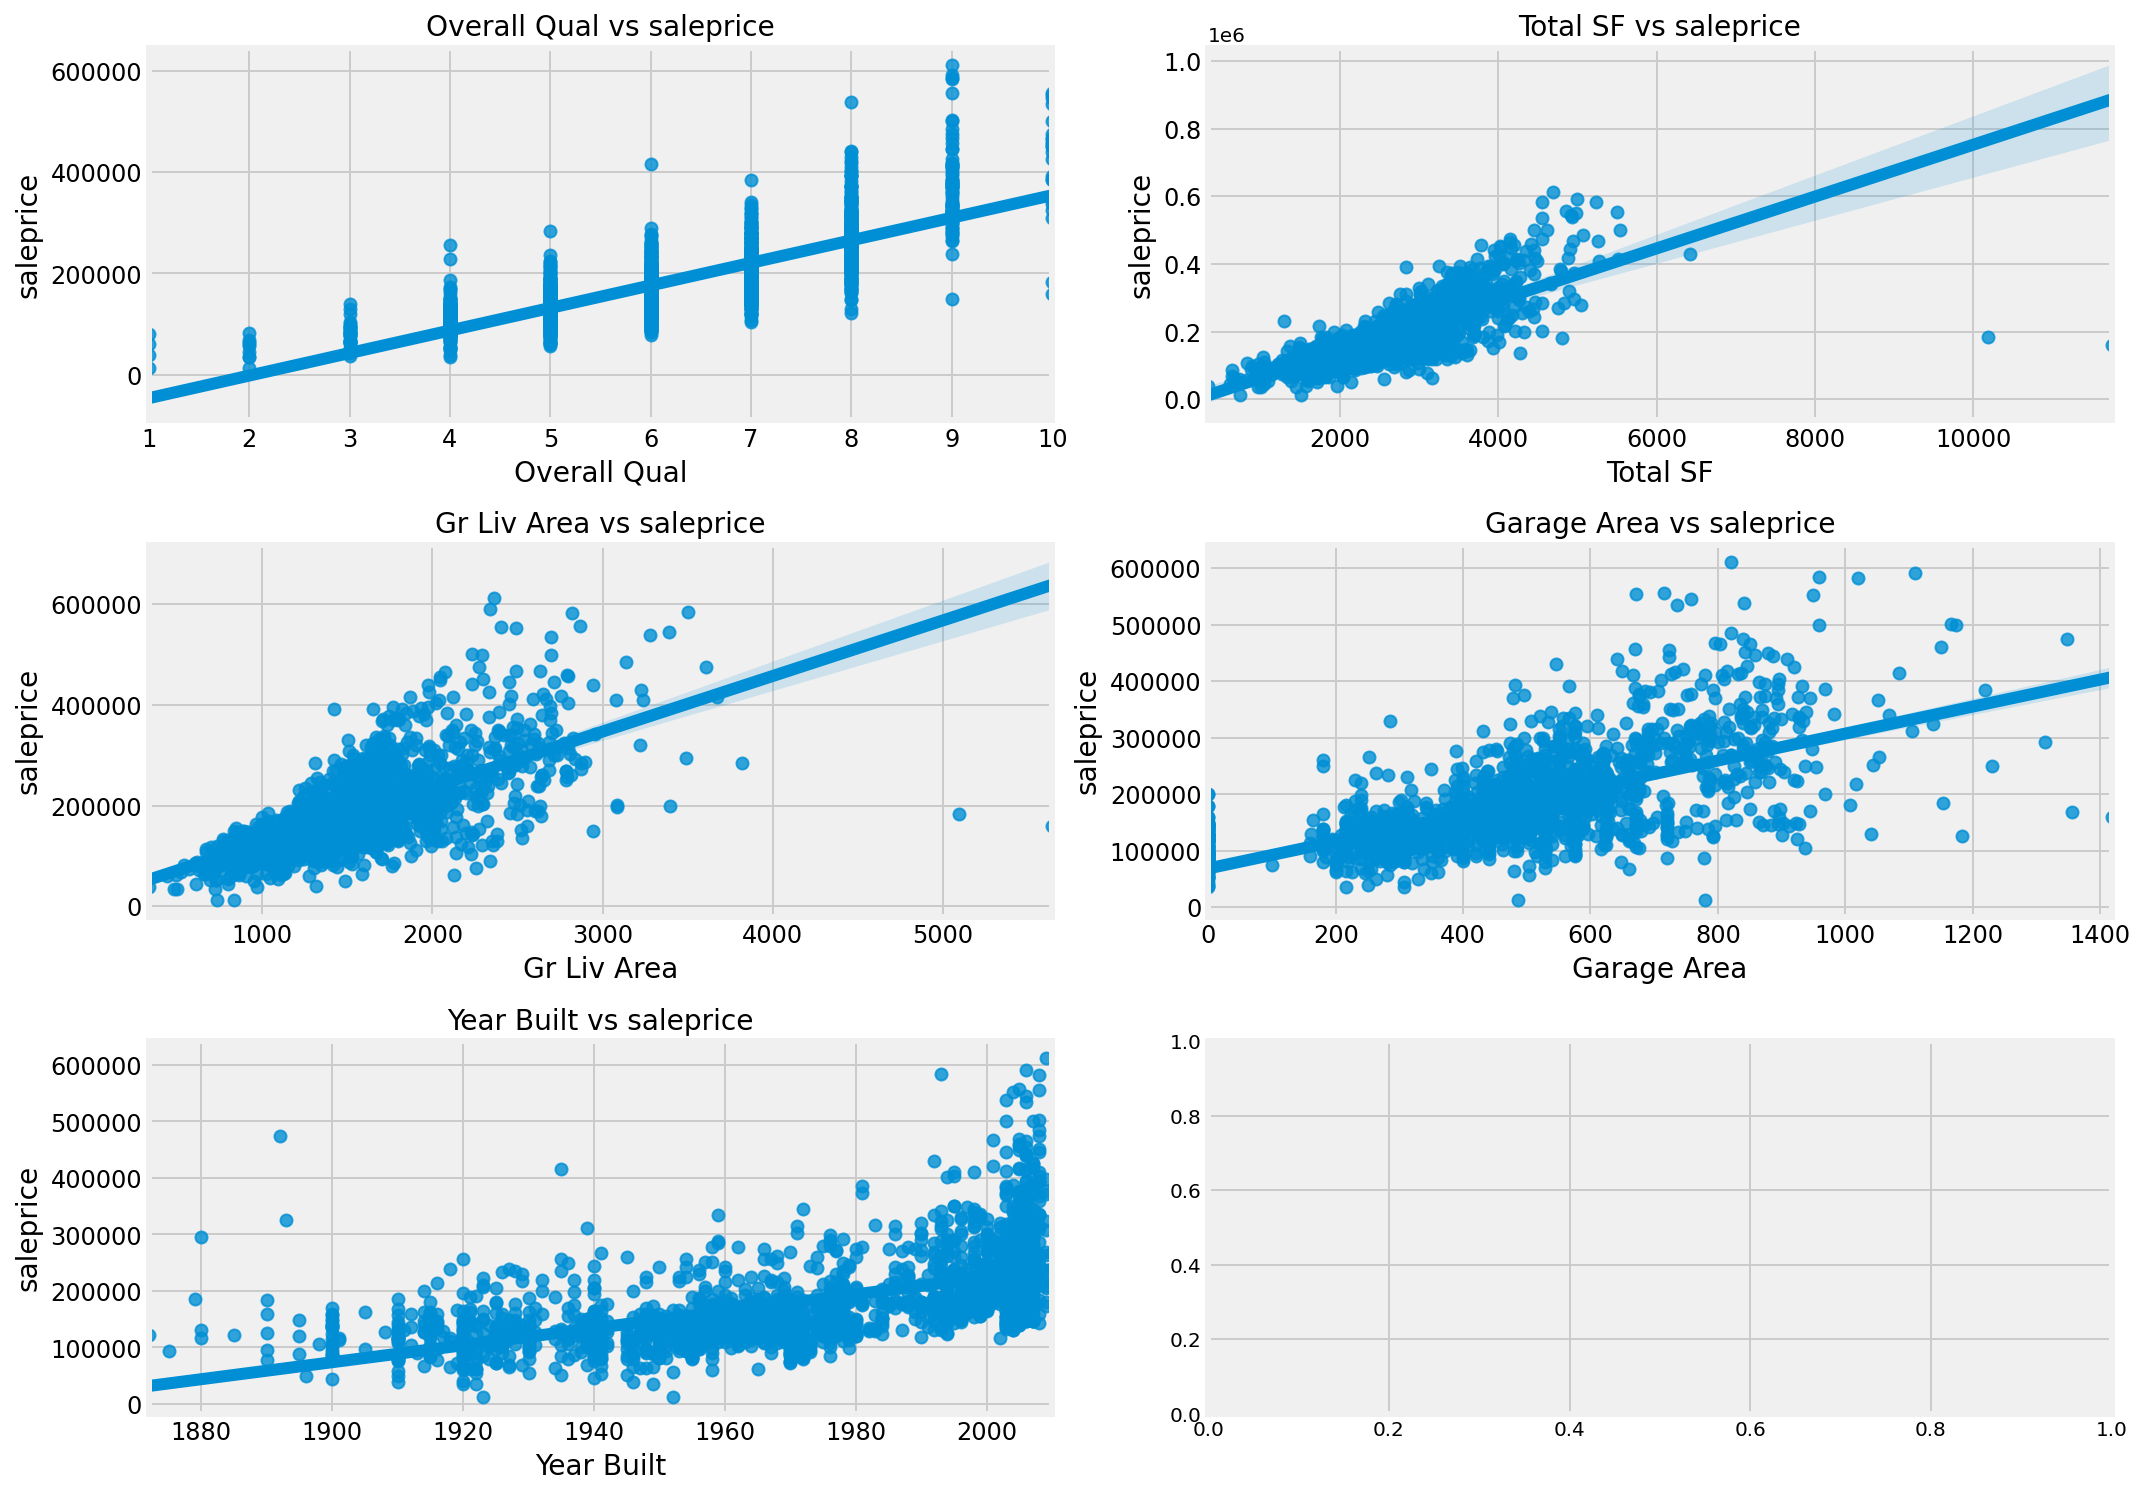

In [19]:
#Plot a subplot of scatterplots with the top variables. 

nrows = int(np.ceil(len(top_df.columns)/2)) 
fig, ax = plt.subplots(nrows=nrows, ncols=2,figsize=(15, nrows*3.5)) 
ax = ax.ravel() 

for i, column in enumerate(top_df.columns):
    sns.regplot(y=train_data.SalePrice, x=train_data[column], ax = ax[i])
    ax[i].set_title(f'{column} vs saleprice',fontsize=14)  
    ax[i].tick_params(labelsize=12)
    ax[i].set_xlabel(column, fontsize=14)
    ax[i].set_ylabel('saleprice', fontsize=14)
plt.tight_layout();


Outliers were observed for both `Gr Liv Area` and `Total SF`. The two outliers of both `Gr Liv Area` and `Total SF` has an are very far apart from the regression line. 

The two points from `Gr Liv Area` and `Total SF` will be removed from the training set so that they do not skew the predictions.

In [20]:
top_df.describe()

Overall Qual      Total SF  Gr Liv Area  Garage Area   Year Built
count   2051.000000   2050.000000  2051.000000  2050.000000  2051.000000
mean       6.112140   2552.096585  1499.330083   473.671707  1971.708922
std        1.426271    809.073286   500.447829   215.934561    30.177889
min        1.000000    334.000000   334.000000     0.000000  1872.000000
25%        5.000000   2006.500000  1129.000000   319.000000  1953.500000
50%        6.000000   2456.000000  1444.000000   480.000000  1974.000000
75%        7.000000   2994.500000  1728.500000   576.000000  2001.000000
max       10.000000  11752.000000  5642.000000  1418.000000  2010.000000

In [21]:
#remove rows where Gr Liv Area > 5000
#remove rows where Total SF > 10000
train_data.drop(train_data.loc[train_data['Gr Liv Area']>5000].index, inplace=True)
train_data.drop(train_data.loc[train_data['Total SF']>10000].index, inplace=True)

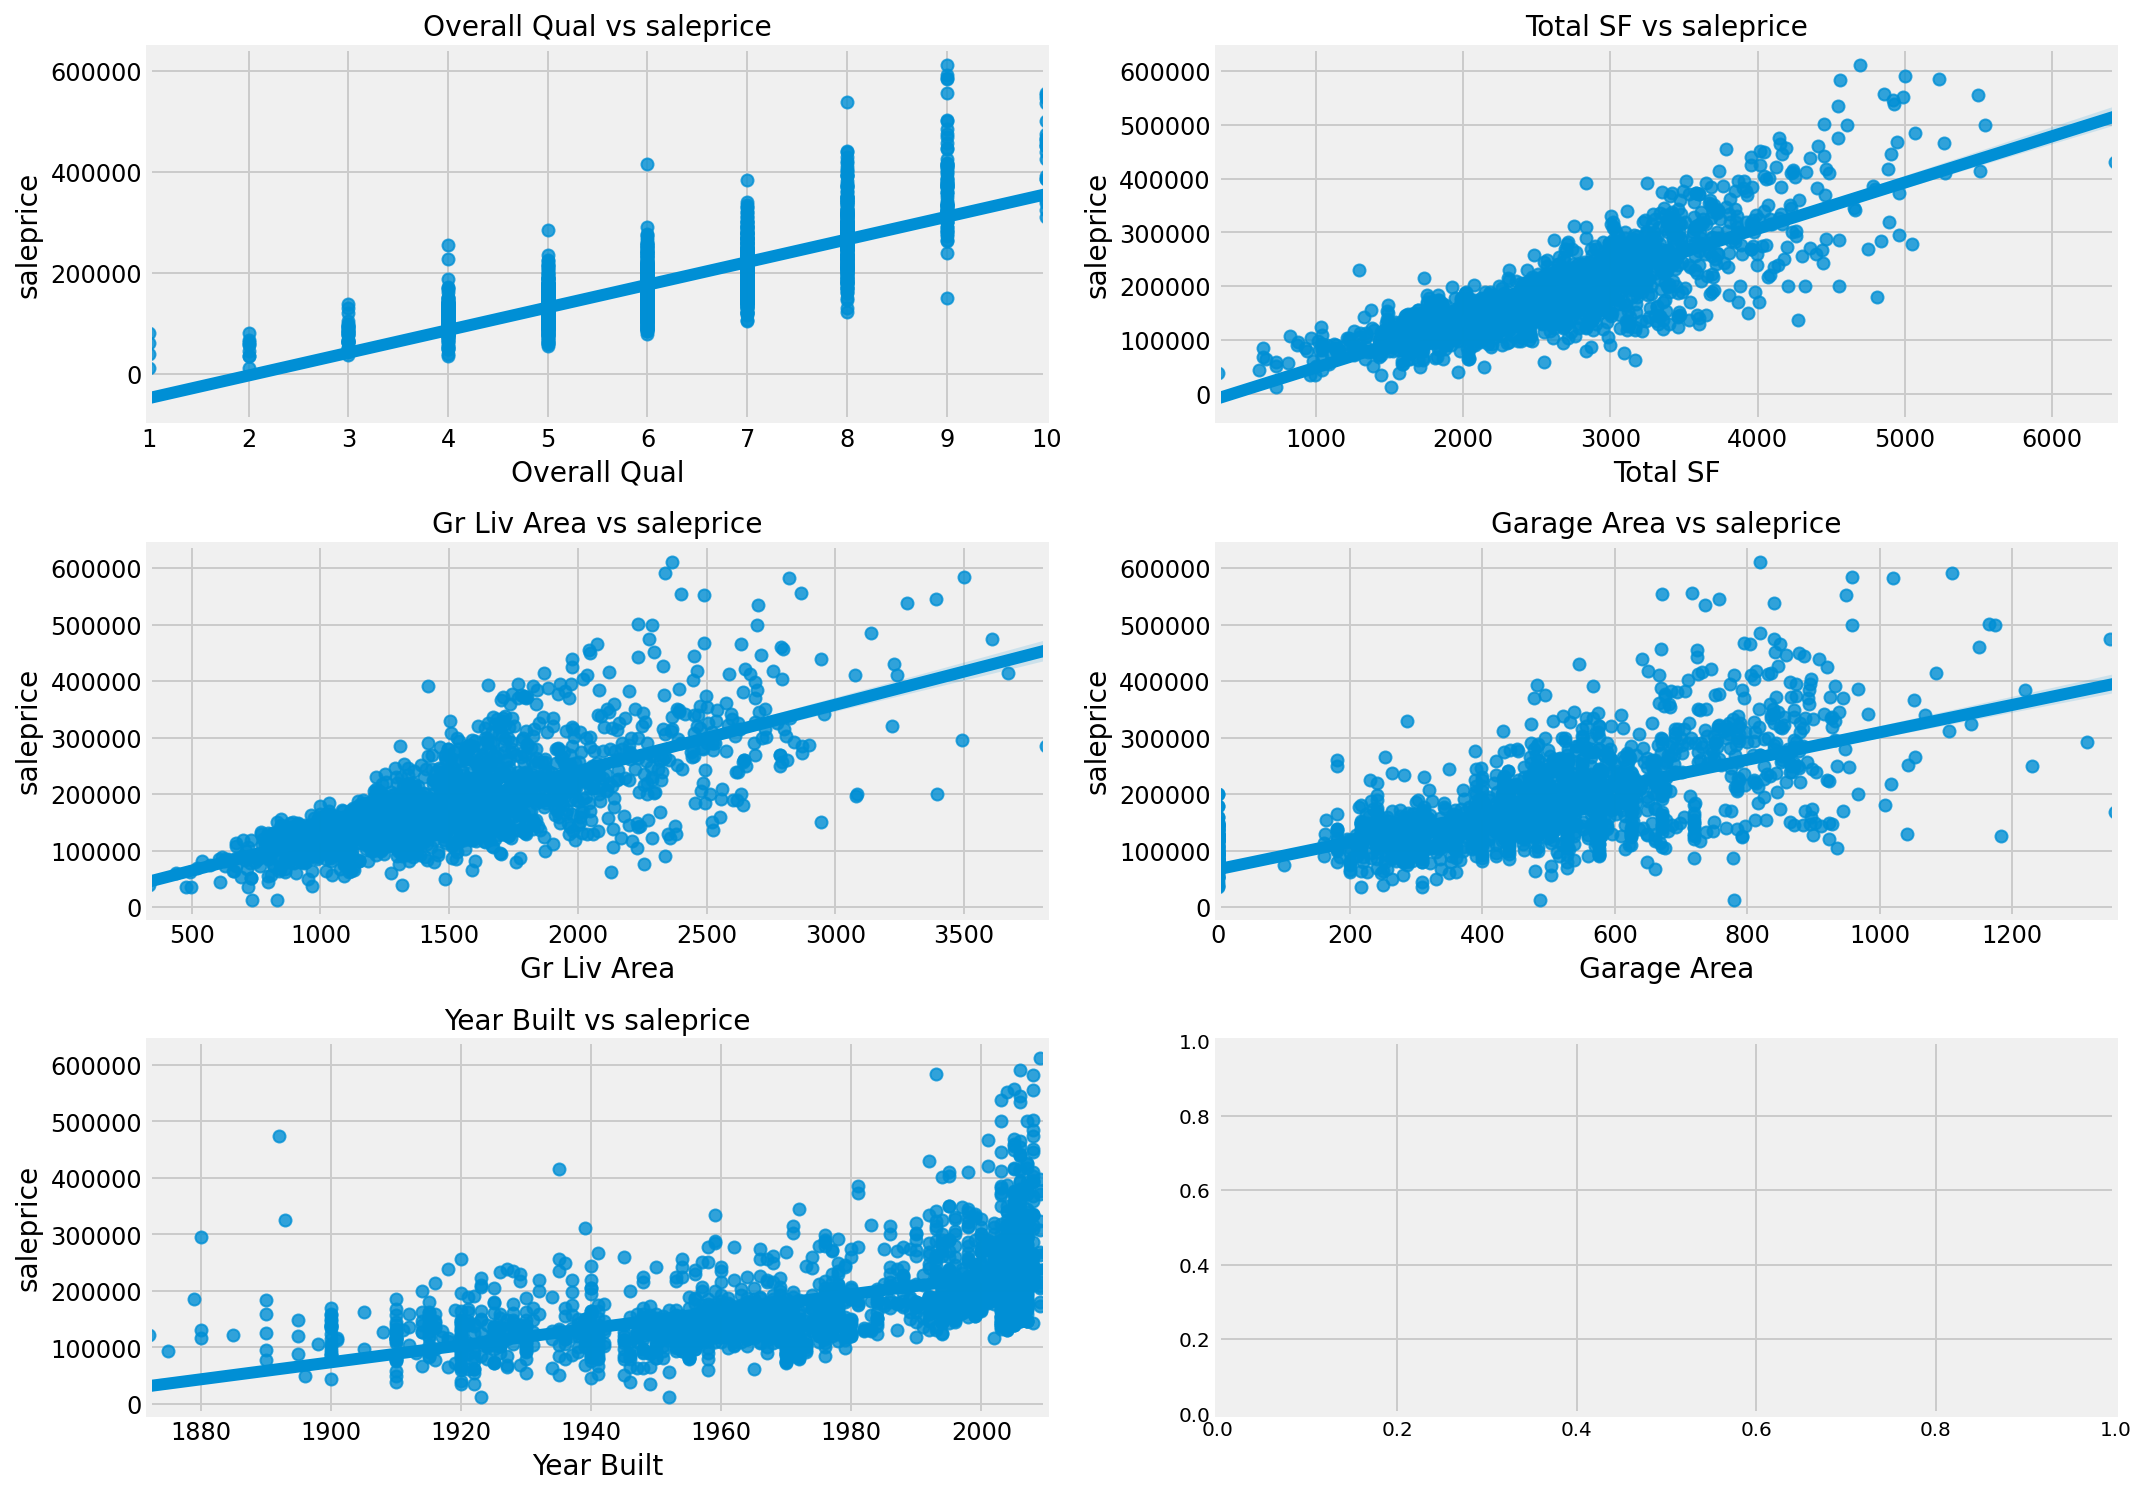

In [22]:
#Plot scatterplots with the top variables after outliers have been removed. 

nrows = int(np.ceil(len(top_df.columns)/2)) 
fig, ax = plt.subplots(nrows=nrows, ncols=2,figsize=(15, nrows*3.5)) 
ax = ax.ravel() 

for i, column in enumerate(top_df.columns):
    sns.regplot(y=train_data.SalePrice, x=train_data[column], ax = ax[i])
    ax[i].set_title(f'{column} vs saleprice',fontsize=14)  
    ax[i].tick_params(labelsize=12)
    ax[i].set_xlabel(column, fontsize=14)
    ax[i].set_ylabel('saleprice', fontsize=14)
plt.tight_layout();


C:\Users\wongs\anaconda3\lib\site-packages\seaborn\axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


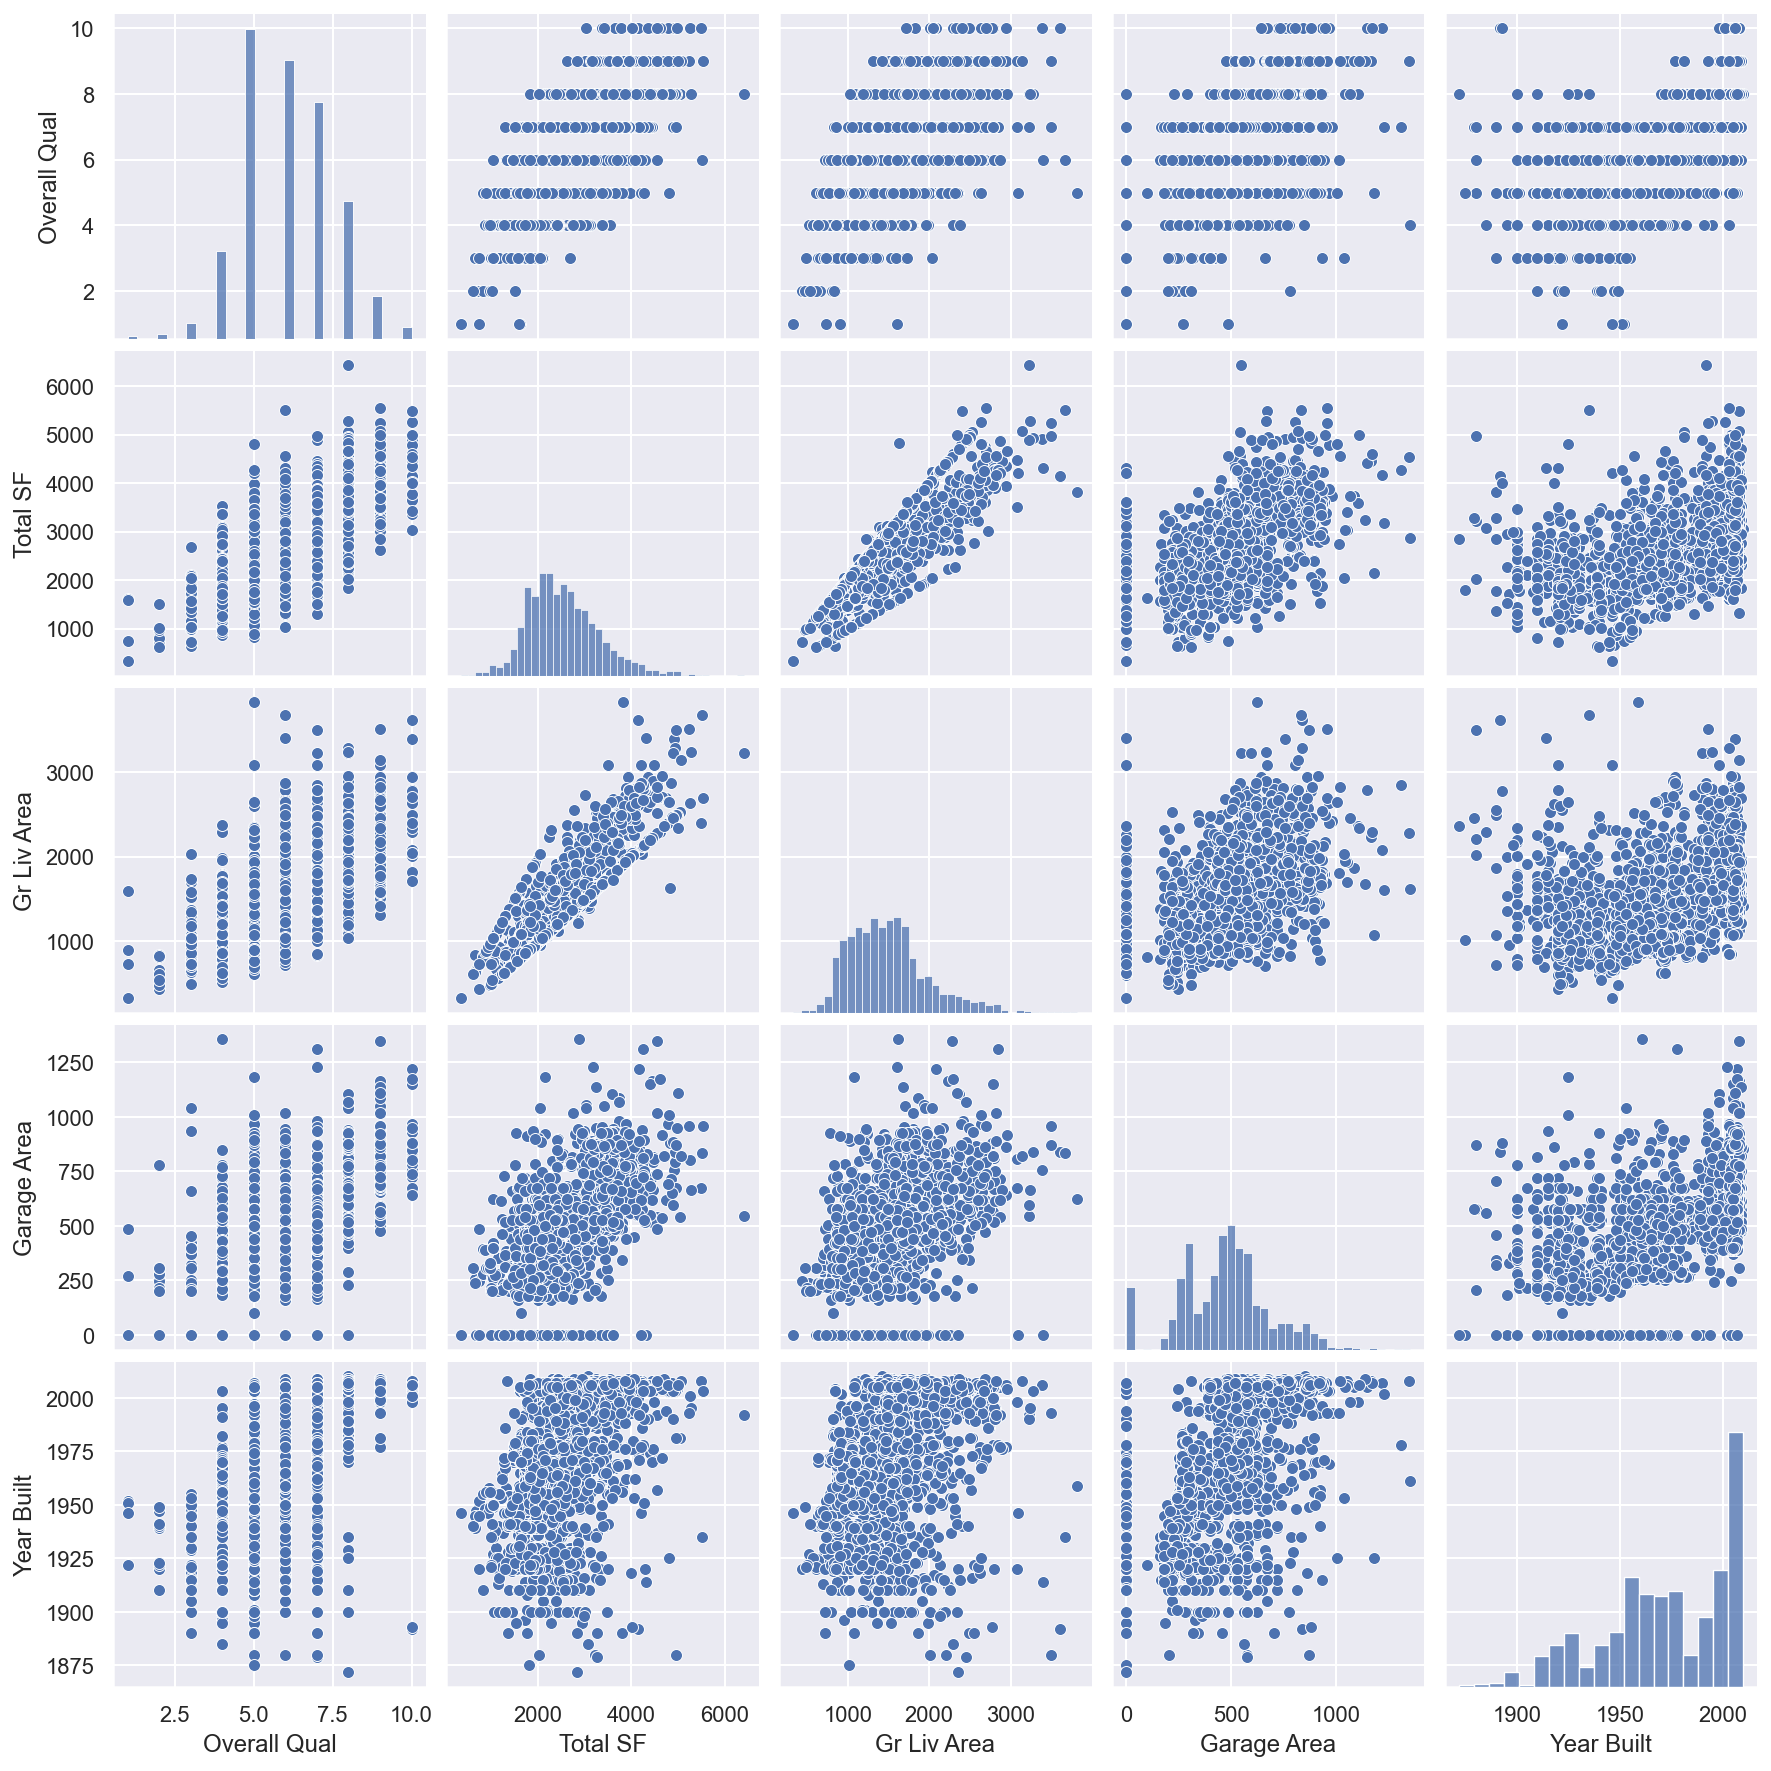

In [23]:
#pairplot top variables with SalePrice

sns.set()
cols = ['Overall Qual' , 'Total SF', 'Gr Liv Area', 'Garage Area', 'Year Built']
sns.pairplot(train_data[cols], size = 2.5)
plt.show();

# 3.4 Analyzing the distribution of the housing sale prices

### Histogram


A histogram of the sale prices was plotted to view the distribution of sale prices. The distribution of the sale prices are skewed to the right and it is observed that the mean is generally to the right of the median. There is a long right-tail observed in sale prices 

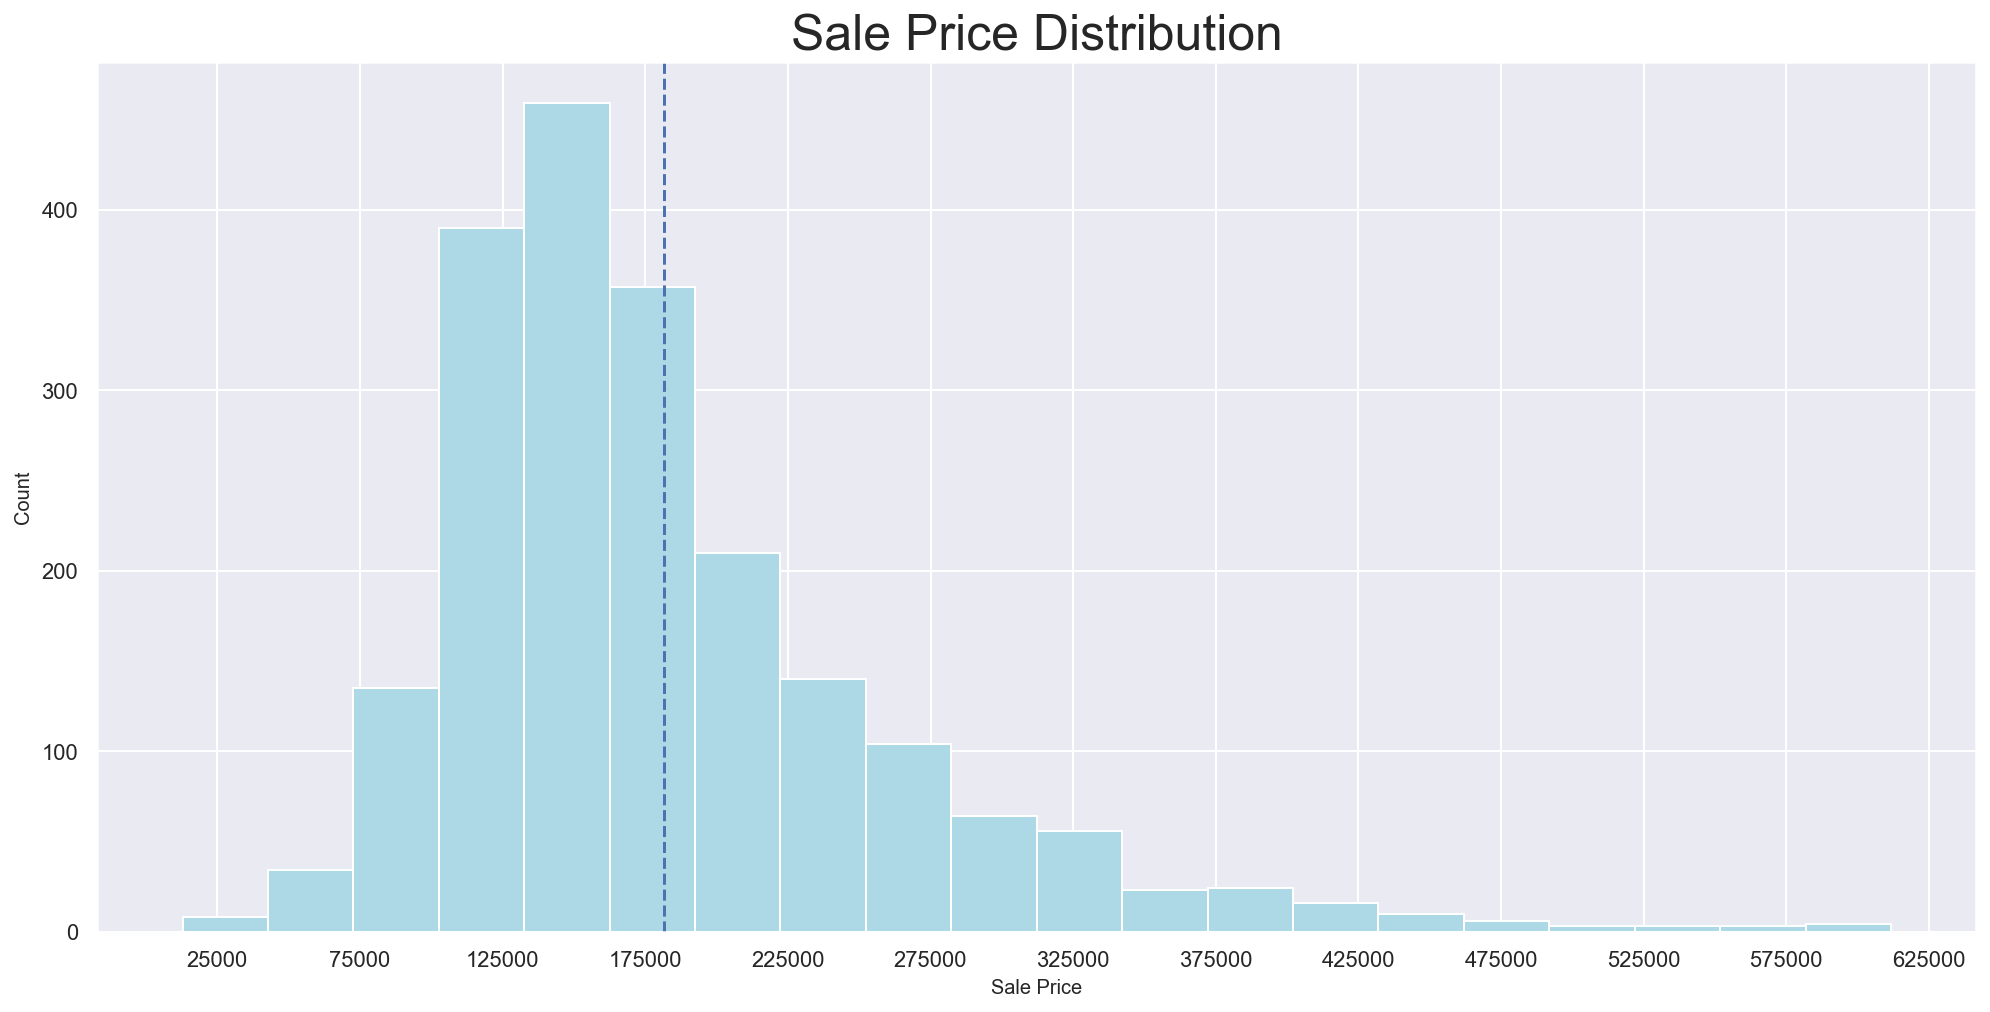

In [24]:
#Plot distribution of Sale Price
plt.figure(figsize=(15,8))

plt.title("Sale Price Distribution", fontsize=25)

plt.xlabel("Sale Price", fontsize=10)
plt.ylabel("Count", fontsize=10)

plt.xticks(range(25000, 625001, 50000))

plt.hist(train_data['SalePrice'], bins=20, color='lightblue')
plt.axvline(np.mean(train_data['SalePrice']), linestyle='dashed');

When the SalePrice does not follow the bell curve, we can log transform this data to make it as “normal” as possible so that the statistical analysis results from this data become more valid. In other words, the log transformation reduces or removes the skewness of our original data. However, after looking at the log transformation of the sale price, it was noted that it did not have a huge impact on the making the data look 'normal'. The data still looked slightly skewed. 

In [25]:
# log SalePrice
train_data.loc[:,'SalePrice'] = np.log(train_data['SalePrice'])

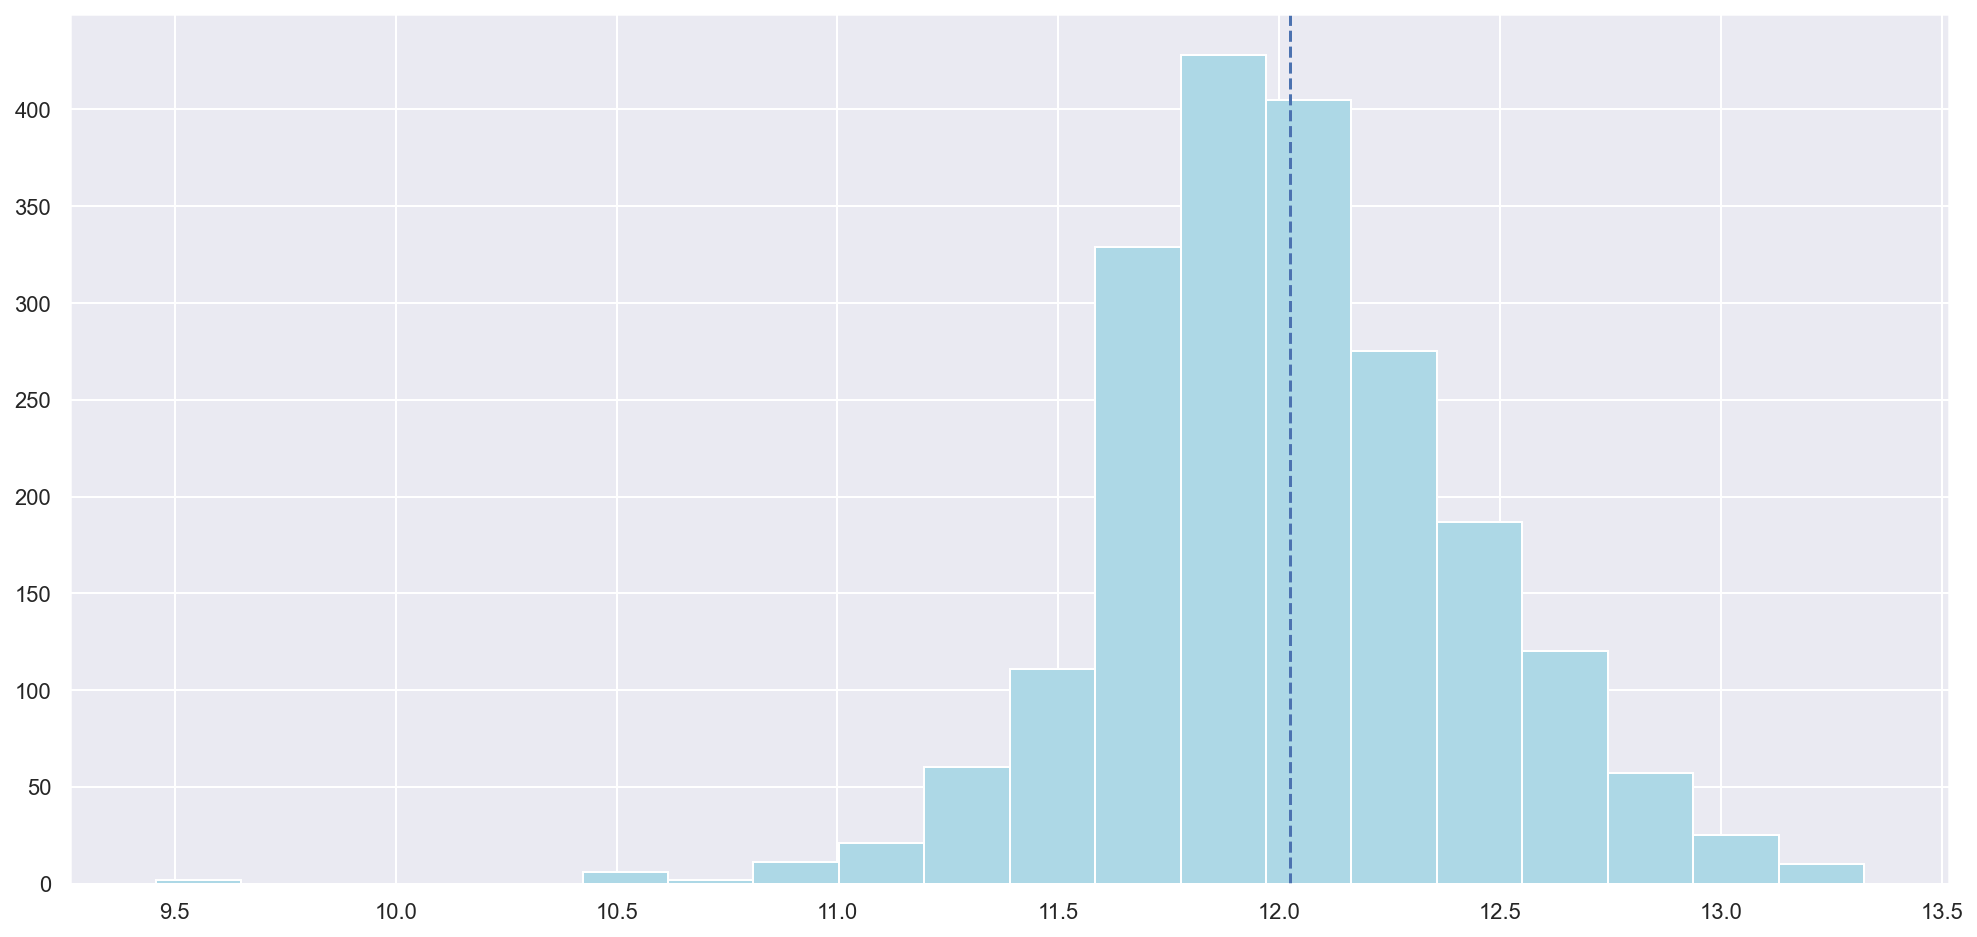

In [26]:
#Plot the distribution of log SalePrice
plt.figure(figsize=(15,8))

plt.hist(train_data['SalePrice'], bins=20, color='lightblue')
plt.axvline(np.mean(train_data['SalePrice']), linestyle='dashed')